<a href="https://colab.research.google.com/github/atlas-github/Lots_of_Useful_Code/blob/master/Introduction_to_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: [Introduction to Random Forests](https://www.datascience.com/resources/notebooks/random-forest-intro)

# Introduction

This piece was adapted with permission from the author from [inertia7.com](https://www.inertia7.com/). View the original [here](https://www.inertia7.com/projects/95). 

Random forests, also known as random decision forests, are a popular ensemble method that can be used to build predictive models for both classification and regression problems. Ensemble methods use multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

To demonstrate how this works in practice — specifically in a classification context — I’ll be walking you through an example using a famous data set from the University of California, Irvine (UCI) Machine Learning Repository. The data set, called the Breast Cancer Wisconsin (Diagnostic) Data Set, deals with binary classification and includes features computed from digitized images of biopsies. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

To follow this tutorial, you will need some familiarity with classification and regression tree (CART) modeling. I will provide a brief overview of different CART methodologies that are relevant to random forest, beginning with decision trees. If you’d like to brush up on your knowledge of CART modeling before beginning the tutorial, I highly recommend reading Chapter 8 of the book “An Introduction to Statistical Learning with Applications in R,” which can be downloaded [here](http://www-bcf.usc.edu/~gareth/ISL/).

# Decision Trees

Decision trees are simple but intuitive models that utilize a top-down approach in which the root node creates binary splits until a certain criteria is met. This binary splitting of nodes provides a predicted value based on the interior nodes leading to the terminal (final) nodes. In a classification context, a decision tree will output a predicted target class for each terminal node produced.

Although intuitive, decision trees have limitations that prevent them from being useful in [machine learning applications](https://www.datascience.com/blog/machine-learning-and-deep-learning-what-is-the-difference). You can learn more about implementing a decision tree [here](http://scikit-learn.org/stable/modules/tree.html).

## Limitations to Decision Trees

Decision trees tend to have high variance when they utilize different training and test sets of the same data, since they tend to overfit on training data. This leads to poor performance on unseen data. Unfortunately, this limits the usage of decision trees in predictive modeling. However, using ensemble methods, we can create models that utilize underlying decision trees as a foundation for producing powerful results.

# Bootstrap Aggregating Trees

Through a process known as bootstrap aggregating (or bagging), it’s possible to create an ensemble (forest) of trees where multiple training sets are generated with replacement, meaning data instances — or in the case of this tutorial, patients — can be repeated. Once the training sets are created, a CART model can be trained on each subsample.

This approach helps reduce variance by averaging the ensemble's results, creating a majority-votes model. Another important feature of bagging trees is that the resulting model uses the entire feature space when considering node splits. Bagging trees allow the trees to grow without pruning, reducing the tree-depth sizes and resulting in high variance but lower bias, which can help improve predictive power.

However, a downside to this process is that the utilization of the entire feature space creates a risk of correlation between trees, increasing bias in the model.

## Limitations to Bagging Trees

The main limitation of bagging trees is that it uses the entire feature space when creating splits in the trees. If some variables within the feature space are indicative of certain predictions, you run the risk of having a forest of correlated trees, thereby increasing bias and reducing variance.

However, a simple tweak of the bagging trees methodology can prove advantageous to the model’s predictive power.

# Random Forest

Random forest aims to reduce the previously mentioned correlation issue by choosing only a subsample of the feature space at each split. Essentially, it aims to make the trees de-correlated and prune the trees by setting a stopping criteria for node splits, which I will cover in more detail later.

After this tutorial you will be familiar with how to implement the following in Python:

* Basic exploratory analysis
* Training and test set creation
* Model fitting using sklearn
* Hyperparameter optimization
* Out-of-bag error rate
* Calculating variable importance
* Test set calculations
* Cross validation
* ROC curve estimation
* Business Uses

## Business Uses

Random Forest can be used for a plethora of data circumstances including, but not limited to:

* [Image classification](https://www.datascience.com/resources/seminar/image-recognition-with-deep-learning)
* Detecting fraudulent cases in banking systems
* [Recommendation engines](https://www.datascience.com/resources/white-papers/introduction-to-recommendation-engines-for-business)
* Feature selection

# Load Packages

To get started, let's load our modules into our Python environment. I am employing a Jupyter Notebook while running inside a virtualenv environment (the **requirements.txt** file associated with [this repo](https://github.com/raviolli77/machineLearning_breastCancer_Python) contains the module information for reproducibility).

For the purposes of this tutorial, I will primarily be using the [SciPy](https://www.scipy.org/stackspec.html) stack, especially **pandas**, **matplotlib**, **seaborn** and **sklearn**.

In [0]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

# Load Data

Let's load the data into a **Pandas** dataframe using **urlopen** from the **urllib.request** module.

Instead of downloading a **csv**, I grabbed the data straight from the [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets.html) using an http request, a method inspired by [Python tutorials](https://github.com/JasonFreeberg/PythonTutorials) from the University of California, Santa Barbara's data science course.

In [0]:
# Loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

I recommend that you keep a static file for your data set as well.

Now, create a list with the appropriate names and set them as the data frame's column names. Then, load them into a pandas data frame.

In [0]:
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

dx = ['Benign', 'Malignant']

In [0]:
breast_cancer = pd.read_csv(urlopen(UCI_data_URL), names=names)

# Cleaning

You'll need to do some minor cleaning, such as setting the **id_number** to the data frame index and converting the **diagnosis** to the standard binary 1, 0 representation using the **map()** function.

In [0]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True)
# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

# Missing Values

Given context of the data set, I know there is no missing data. Even so, let's run a for-loop to see if there are any missing values in our columns. Below, you'll see the column name and total missing values for that column.

In [42]:
for col in breast_cancer:
    if ((breast_cancer[col].isnull().values.ravel().sum()) == 0):
        pass
    else:
        print(col)
        print((breast_cancer[col].isnull().values.ravel().sum()))
print(r'Sanity Check! \No missing Values found!')

Sanity Check! \No missing Values found!


Sanity check! No missing values found! We'll use this for the random forest model, where the **id_number** won't be relevant.

In [0]:
# For later use in CART models
names_index = names[2:]

Let's preview the data set utilizing the **head()** function, which will provide the first five values of our data frame.

In [44]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Next, let's get the dimensions of the data set. The first value is the number of patients and the second value is the number of features. It's important to print the data types of your data set, as it will often be an indicator of missing data — and provide context for additional data cleaning.

In [45]:
print("Here's the dimensions of our data frame:\n",
     breast_cancer.shape)
print("Here's the data types of our columns:\n",
     breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (569, 31)
Here's the data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64

# Class Imbalance

The distribution of diagnoses is important because it speaks to class imbalance within machine learning and data mining applications. Class imbalance is a term used to describe when a target class within a data set is outnumbered by another target class (or classes). This can create misleading accuracy metrics, known as an accuracy paradox. To make sure our target classes aren't imbalanced, create a function that will output the distribution of the target classes.

**Note**: If your data set suffers from class imbalance, I suggest reading up on upsampling and downsampling.

In [0]:
def print_dx_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    dx_vals = data_frame[col].value_counts()
    dx_vals = dx_vals.reset_index()
    # Create a function to output the percentage
    f = lambda x, y: 100 * (x / sum(y))
    for i in range(0, len(dx)):
        print('{0} accounts for {1:.2f}% of the diagnosis class'\
          .format(dx[i], f(dx_vals[col].iloc[i],
                           dx_vals[col])))

In [47]:
print_dx_perc(breast_cancer, 'diagnosis')

Benign accounts for 62.74% of the diagnosis class
Malignant accounts for 37.26% of the diagnosis class


Benign results account for 62.74% of the diagnosis class. Malignant results account for 37.26% of the diagnosis class. Fortunately, this data set does not suffer from class imbalance.

Next, we will employ a function that gives us standard descriptive statistics for each feature including mean, standard deviation, minimum value, maximum value, and range intervals.



In [48]:
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


You can see in the maximum row of the chart that our data varies in distribution; this will be important as we consider classification models. Standardization is an important requirement for many classification models that should be handled when implementing pre-processing. Some models (like [neural networks](https://www.datascience.com/resources/webinars/introduction-to-neural-nets-with-the-data-incubator)) can perform poorly if pre-processing isn't considered, so the **describe()** function is a good indicator for standardization. Fortunately, random forest does not require any pre-processing. (For use of categorical data, see sklearn's [Encoding Categorical Data](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features).)

# Creating Training and Test Sets

Let's split the data set into our training and test sets, which will be pseudo-randomly selected to create a 80-20% split. You will use the training set to train the model and perform some optimization. You will use the test set, which will act as unseen data, to assess model performance.

When using this method for machine learning, always be wary of utilizing your test set to create models. Data leakage is a common problem that can result in overfitting. More on data leakage can be found in this [Kaggle article](https://www.kaggle.com/wiki/Leakage).

In [0]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']


training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20,
                                                                    random_state = 42)

**Note**: What I mean when I say that we will "pseudo-randomly" select data is that we will use a random seed generator and set it equal to a number of our choosing. This will ensure the results are the same for anyone who uses this generator, and therefore, that they will be able to replicate this project. 

In [0]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel()
test_class_set = test_class_set.values.ravel()

# Fitting Random Forest

Now, let's create the model, starting with parameter tuning. Here are the parameters we will be tuning in this tutorial: 

* **max_depth**: The maximum splits for all trees in the forest.
* **bootstrap**: An indicator of whether or not we want to use bootstrap samples when building trees.
* **max_features**: The maximum number of features that will be used in node splitting — the main difference I previously mentioned between bagging trees and random forest. Typically, you want a value that is less than p, where p is all features in your data set.
* **criterion**: This is the metric used to asses the stopping criteria for the decision trees.
Once we've instantiated our model, we will go ahead and tune our parameters.

In [0]:
# Set the random state for reproductibility
fit_rf = RandomForestClassifier(random_state=42, n_estimators = 100)

# Hyperparameter Optimization

Utilizing the **GridSearchCV** functionality, let's create a dictionary with parameters we are looking to optimize to create the best model for our data. Setting the **n_jobs** to 3 tells the grid search to run three jobs in parallel, reducing the time the function will take to compute the best parameters. I included the timer to see how long different jobs took; that led me to ultimately decide to use three parallel jobs.

This will help set the parameters we will use to tune one final parameter: the number of trees in our forest.

In [52]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist,
                     n_jobs = 3, iid = True)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n',
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}
Time taken in grid search:  82.97


Once we find the best parameter combination, we can set the parameters to our model.

Notice how I didn't use the **bootstrap: True** parameter. I will explain why in the following section.

In [53]:
# Set best parameters given by grid search
fit_rf.set_params(criterion = 'entropy',
                  max_features = 'log2',
                  max_depth = 4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Out-of-Bag Error Rate

Another useful feature of random forest is the concept of an out-of-bag (OOB) error rate. Because only two-thirds of the data are used to train each tree when building the forest, one-third of unseen data can be used in a way that is advantageous to our accuracy metrics without being as computationally expensive as something like cross validation, for instance.

As outlined below, when calculating OOB, two parameters have to be changed. Also, by utilizing a **for-loop** across a multitude of forest sizes, we can calculate the OOB error rate and use it to asses how many trees are appropriate for our model!

**Note**: When calculating the OOB score, setting **bootstrap: True** will produce errors, but it is necessary to complete the **oob_score** calculation, as outlined in this [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

For the original analysis I compared k-nearest neighbors, random forest, and [neural networks](https://www.datascience.com/resources/webinars/introduction-to-neural-nets-part-2), so most of the analysis was done to compare across different models.

In [0]:
fit_rf.set_params(warm_start=True,
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [0]:
# Convert dictionary to a pandas series for easy plotting
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

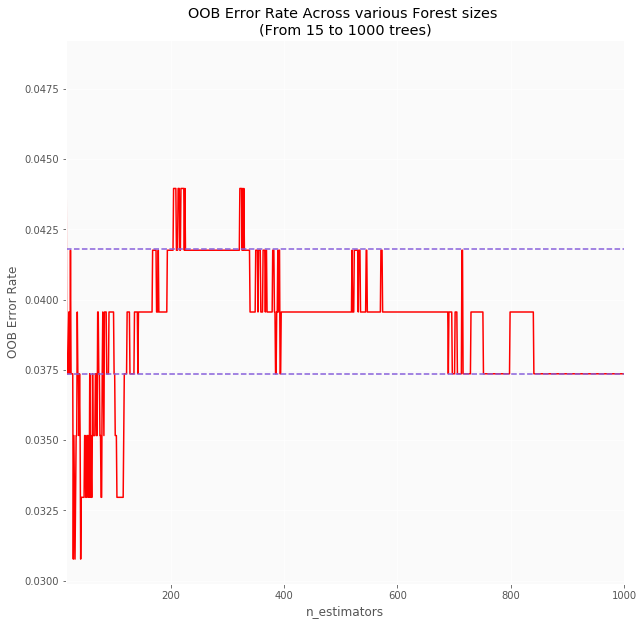

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.0418,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.03735,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

The OOB error rate starts to oscillate at around 400 trees, so I will go ahead and use 400 trees in my forest. Using the pandas series object, I can easily find the OOB error rate for the estimator as follows:

In [68]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

OOB Error rate for 400 trees is: 0.03956


Utilizing the OOB error rate that was created with the model gives us an unbiased error rate. Since OOB can be calculated with the model estimation, it's helpful when cross validating and/or optimizing hyperparameters prove to be too computationally expensive.

For the sake of this tutorial, I will go over other traditional methods for optimizing machine learning models, including the training and test error route and cross validation metrics.

# Traditional Training and Test Set Split

In order for this methodology to work, we must set the number of trees calculated using the OOB error rate, and remove the **warm_start** and **oob_score** parameters, as well as include the **bootstrap** parameter.

In [71]:
fit_rf.set_params(n_estimators=400,
              bootstrap = True,
              warm_start=False,
              oob_score=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Training the Algorithm

Next, let's train the algorithm with the training and target class data sets we made earlier.

In [72]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Variable Importance

Once we have trained the model, we can assess variable importance. One downside to using ensemble methods with decision trees is that you lose the [interpretability](https://www.datascience.com/resources/webinars/model-agnostic-interpretation-algorithms) a single tree gives. A single tree can outline for us important node splits, as well as variables that were important at each split.

Fortunately, ensemble methods that rely on CART models use a metric to evaluate the homogeneity of splits. Thus, when creating ensembles, these metrics can be utilized to give insight into the important variables used in the training of the model. Two such metrics are **gini impurity** and **entropy**. Many people favor **gini impurity** because it has a lower computational cost than **entropy**, which requires calculating the logarithmic function. For more information, I recommend reading this [article](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md).

Here we define each metric:

$GiniImpurity = 1 - \sum_ip_i$

and

$Entropy = \sum_i - p_i*\log_2p_i$

where $p_i$ is defined as the proportion of subsamples that belong to a certain target class.

Since we are utilizing the **gini impurity**, the impurity measure reaches 0 when all target class labels are the same.

Let's access the feature importance of the model and use a helper function to output the importance of our variables in descending order.

In [0]:
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [0]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")

    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1,
                                         names_index[indices[i]],
                                         importance[indices[f]]))

In [75]:
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Gini of 0.126025
2. The feature 'perimeter_worst' has a Mean Decrease in Gini of 0.112596
3. The feature 'concave_points_worst' has a Mean Decrease in Gini of 0.111562
4. The feature 'concave_points_mean' has a Mean Decrease in Gini of 0.092333
5. The feature 'radius_worst' has a Mean Decrease in Gini of 0.075607
6. The feature 'concavity_mean' has a Mean Decrease in Gini of 0.058079
7. The feature 'area_mean' has a Mean Decrease in Gini of 0.048655
8. The feature 'concavity_worst' has a Mean Decrease in Gini of 0.048258
9. The feature 'radius_mean' has a Mean Decrease in Gini of 0.046903
10. The feature 'perimeter_mean' has a Mean Decrease in Gini of 0.044660
11. The feature 'area_se' has a Mean Decrease in Gini of 0.040330
12. The feature 'texture_worst' has a Mean Decrease in Gini of 0.024611
13. The feature 'compactness_worst' has a Mean Decrease in Gini of 0.019897
14. The feature 'texture_mean' has a Mean Decreas

We can see here that our top five variables are **area_worst**, **perimeter_worst**, **concave_points_worst**, **concave_points_mean**, **radius_worst**.

This gives us great insight for further analyses like feature engineering, although I won't get into that topic during this tutorial. It can also give us insight into the mind of the practitioner by showing what variables played an important part in the predictions generated by the model. In the case of our test data set, knowing this information would help practitioners in the medical field focus on the top variables and their relationship with breast cancer.

In [0]:
def variable_importance_plot(importance, indices):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order

    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(29, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

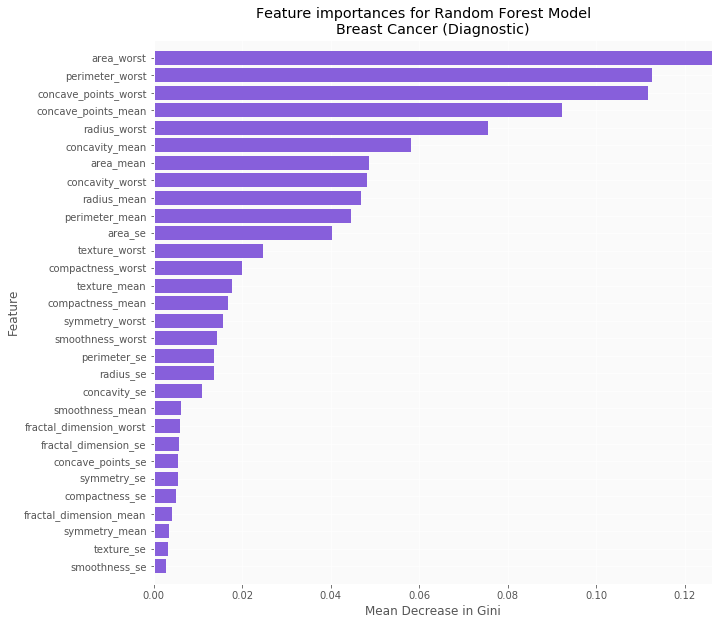

In [79]:
variable_importance_plot(importances_rf, indices_rf)

The visual above helps drive home the point, since you can clearly see the difference in the importance of variables for the ensemble method. Certain cutoff points can be made to reduce the inclusion of features and can help in the accuracy of the model, since we'll be removing what is considered noise within our feature space.

# Cross Validation

Cross validation is a powerful tool that is used for estimating the predictive power of your model, and it performs better than the conventional training and test set. Using cross validation, we can create multiple training and test sets and average the scores to give us a less biased metric.

In this case, we will create 10 sets within our data set that calculate the estimations we have done already, then average the prediction error to give us a more accurate representation of our model's prediction power. The model's performance can vary significantly when utilizing different training and test sets.

For a more thorough explanation of cross validation I recommend reading [An Introduction to Statistical Learnings with Applications in R](http://www-bcf.usc.edu/~gareth/ISL/), specifically chapter 5.1. 

# K-Fold Cross Validation

Here we are employing K-fold cross validation; more specifically, 10 folds. We are creating 10 subsets of our data on which to employ the training and test set methodology; then we will average the accuracy for all folds to give us our estimation.

Within a random forest context, if your data set is significantly large, you can choose to not do cross validation and instead use the OOB error rate as an unbiased metric for computational costs. But for the purposes of this tutorial, I included it to show the different accuracy metrics available.

In [0]:
def cross_val_metrics(fit, training_set, class_set, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues
                  for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as
                  variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
            from cross validation score's standard deviation)
    """
    n = KFold(n_splits=10)
    scores = cross_val_score(fit,
                     training_set,
                     class_set,
                     cv = n)
    if print_results:
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
          .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [81]:
cross_val_metrics(fit_rf,
              training_set,
              class_set,
              print_results = True)

Accuracy:  0.960 (+/-  0.013)


# Test Set Metrics

Using the test set that was created earlier, let's examine another metric for the evaluation of our model. You'll recall that that we didn't touch the test set until now — after we had completed hyperparamter optimization — to avoid the problem of data leakage. 

Here, I have created a confusion matrix showcasing the following metrics:

| n = Sample Size | Predicted Benign | Predicted Malignant |
| -- | -- | -- |
|Actual Benign | *True Positive* | *False Negative* |
| Actual Malignant | *False Positive* | *True Negative* |

In [0]:
predictions_rf = fit_rf.predict(test_set)

In [0]:
test_crosstb = pd.crosstab(index = test_class_set,
                           columns = predictions_rf)

# More human readable
test_crosstb = test_crosstb.rename(columns= {0: 'Benign', 1: 'Malignant'})
test_crosstb.index = ['Benign', 'Malignant']
test_crosstb.columns.name = 'n = 114'

In [84]:
test_crosstb

n = 114,Benign,Malignant
Benign,70,1
Malignant,3,40


In [85]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


In [86]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


As you can see, we got a very similar error rate for our test set to the one we got with our OOB, which is a good sign for our model.

# ROC Curve Metrics

A receiver operating characteristic (ROC) curve calculates the false positive rates and true positive rates across different thresholds. Let's graph these calculations.

If our curve is located in the top left corner of the plot, that indicates an ideal model; i.e., a false positive rate of 0 and true positive rate of 1. On the other hand, a ROC curve that is at 45 degrees is indicative of a model that is essentially randomly guessing.

We will also calculate the area under the curve (AUC). The AUC is used as a metric to differentiate the prediction power of the model for patients with cancer and those without it. Typically, a value closer to 1 means that our model was able to differentiate correctly from a random sample of the two target classes of two patients with and without the disease.

In [0]:
fpr2, tpr2, _ = roc_curve(predictions_rf,
                      test_class_set)
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

In [0]:
auc_rf = auc(fpr2, tpr2)

In [0]:
def plot_roc_curve(fpr, tpr, auc, mod, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    fpr:  Array returned from sklearn.metrics.roc_curve for increasing
         false positive rates
    tpr:  Array returned from sklearn.metrics.roc_curve for increasing
         true positive rates
    auc:  Float returned from sklearn.metrics.auc (Area under Curve)
    mod:  String represenation of appropriate model, can only contain the
         following: ['knn', 'rf', 'nn']
    xlim: Set upper and lower x-limits
    ylim: Set upper and lower y-limits

    Returns:
    ----------
    Returns plot of Receiving Operating Curve for specific model. Allowing user to
    specify x and y-limits.
    """
    mod_list = ['knn', 'rf', 'nn']
    method = [('Kth Nearest Neighbor', 'deeppink'),
          ('Random Forest', 'red'),
          ('Neural Network', 'purple')]

    plot_title = ''
    color_value = ''
    for i in range(0, 3):
        if mod_list[i] == mod:
            plot_title = method[i][0]
            color_value = method[i][1]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
         color=color_value,
         linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f}) \
          \nBreast Cancer Diagnostic'\
          .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

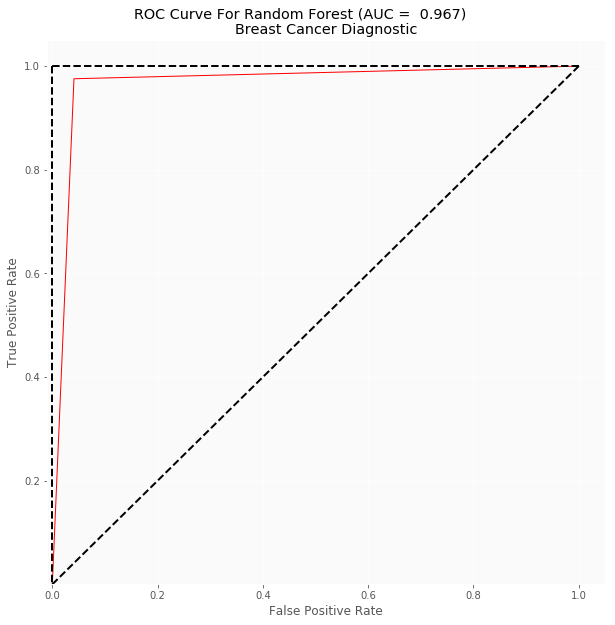

In [90]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
           xlim=(-0.01, 1.05),
           ylim=(0.001, 1.05))

Our model performed exceptionally well — it has an AUC over .90. Now, let's take a zoomed-in view to showcase the closeness of our ROC curve to the ideal ROC curve.

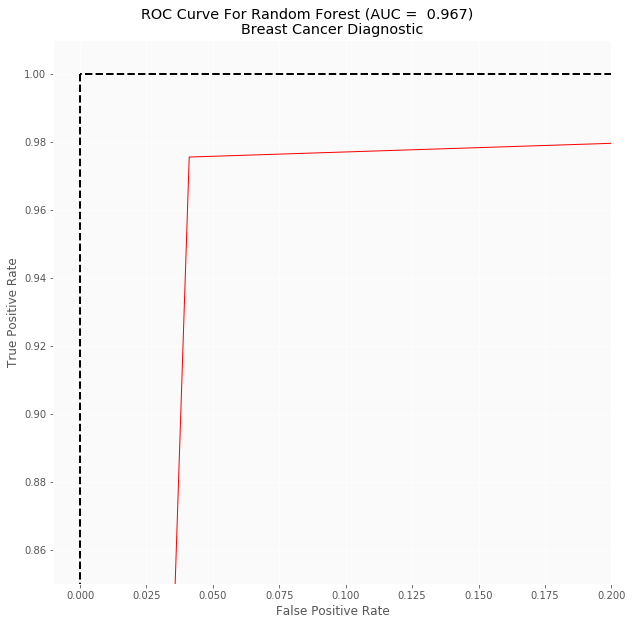

In [91]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 0.2),
               ylim=(0.85, 1.01))

# Classification Report

I'm going to go ahead and create a classification report for our model, which is available through **sklearn.metrics**. This report provides many important classification metrics including:

* **Precision**: Also called the positive predictive value, this metric is the number of correct predictions divided by the number of correct predictions plus false positives, so $\frac {tp}{tp + fp}$.
* **Recall**: Also known as the sensitivity, this is the number of correct predictions divided by the total number of instances, so $\frac{tp}{tp + fn}$ where $fn$ is the number of false negatives.
* **f1-score**: This is defined as the *weighted harmonic mean* of both the precision and recall, where the best f1-score is 1 and this worst value is 0, as defined by sklean's [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support).
* **support**: The number of instances that are the correct target values.

Across the board, we can see that our model provided great insight into classifying patients based on FNA scans. Other important metrics to consider would be the false positive rate, since within this context it would be bad for the model to tell someone that they are cancer free when in reality they have cancer.

In [101]:
def print_class_report(predictions, alg_name): """
Purpose
----------
Function helps automate the report generated by the sklearn package. Useful for multiple model comparison

Parameters
----------
Predictions:
The predictions made by the algorithm used alg_name: String containing the name of the algorithm used

Returns:
----------
Returns classification report generated from sklearn.
"""
print('Classification Report for {0}:'.format(alg_name))
print(classification_report(predictions,
        test_class_set,
        target_names = dx))

NameError: ignored

In [0]:
class_report = print_class_report(predictions_rf, 'Random Forest')

# Metrics for Random Forest

Here, I've accumulated the various metrics we have used throughout this tutorial in a simple table to showcase the power and effectiveness of random forest modeling.

| Model | OOB Error Rate | Test Error Rate | Cross Validation Score | AUC |
| -- | -- | -- | -- | -- |
| Random Forest | 0.04835 | 0.0351 | 0.947 (+/- 0.019) | 0.967 |

# Conclusions

We've now gone through a number of metrics to assess the capabilities of our random forest, but there's still much that can be done using background information from the data set. [Feature engineering](https://www.datascience.com/blog/feature-engineering-for-churn-modeling) would be a powerful tool for extracting information and moving forward into the research phase, and would help define key metrics to utilize when optimizing model parameters.

There have been advancements with [image classification](https://www.datascience.com/resources/seminar/image-recognition-with-deep-learning) in the past decade that make it possible to use images instead of extracted features from those images, but this data set is a great resource for making use of machine learning processes and concepts. If you have any suggestions, recommendations, or corrections please reach out to me.